In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss, confusion_matrix, roc_curve, roc_auc_score,recall_score
import matplotlib.pyplot as plt


data = pd.read_csv(r"C:\Users\beher\OneDrive\Desktop\NEW_METHOD\data_wo_cluster.csv")


data = data.sample(frac=1).reset_index(drop=True)


X = data.drop(columns=['CLASS'])
y = data['CLASS']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


categorical_cols = [col for col in X_train.columns if X_train[col].dtype == 'object']
numerical_cols = [col for col in X_train.columns if col not in categorical_cols]

In [2]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Fit and transform the training data
preprocessor.fit(X_train)
X_train_encoded = preprocessor.transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

In [3]:
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(X_train_encoded, y_train)

SVC(probability=True, random_state=42)

In [4]:
y_test_pred = svm_classifier.predict(X_test_encoded)

In [5]:
y_test_pred_prob = svm_classifier.predict_proba(X_test_encoded)

True Positive Rate (TPR): 0.7510204081632653
False Positive Rate (FPR): 0.24151696606786427
False Negative Rate (FNR): 0.24897959183673468
True Negative Rate (TNR): 0.7584830339321357
Accuracy: 0.7547931382441978
Recall 0.7510204081632653
Precision: 0.7525562372188139
F1 Score: 0.7517875383043923
Log Loss: 0.5225762290376716
ROC AUC Score: 0.8189376349342132


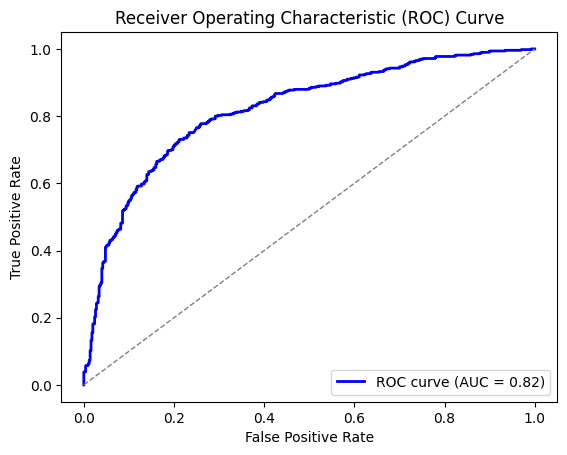

In [6]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

TP = conf_matrix[1, 1]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]
FN = conf_matrix[1, 0]

accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
logloss = log_loss(y_test, y_test_pred_prob)
roc_auc = roc_auc_score(y_test, y_test_pred_prob[:, 1])
TPR = TP / (TP + FN)
FPR = FP / (FP + TN)
FNR = FN / (FN + TP)
TNR = TN / (TN + FP)

print("True Positive Rate (TPR):", TPR)
print("False Positive Rate (FPR):", FPR)
print("False Negative Rate (FNR):", FNR)
print("True Negative Rate (TNR):", TNR)

print("Accuracy:", accuracy)
print("Recall", recall)
print("Precision:", precision)
print("F1 Score:", f1)
print("Log Loss:", logloss)
print("ROC AUC Score:", roc_auc)

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_prob[:, 1])
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Confusion Matrix:
[[380 121]
 [122 368]]


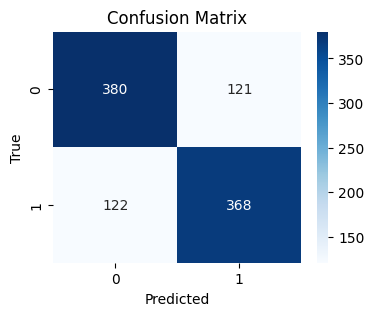

In [7]:
import seaborn as sns
print("Confusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(4, 3))  # Adjust the figsize as needed
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [8]:
new_data = pd.read_csv(r"C:\Users\beher\OneDrive\Desktop\NEW_METHOD\NEW_TESTING.csv")
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['Aspect', 'Curvature', 'Dist_from_Lineaments',
                                  'Slope', 'SPI', 'TRI']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['LULC', 'Geomorphology', 'Soil',
                                  'Lithology'])])

In [15]:
X_new_encoded = preprocessor.transform(new_data)

In [16]:
y_pred_prob_new = svm_classifier.predict_proba(X_new_encoded)

In [17]:
import pandas as pd

prob_df = pd.DataFrame(y_pred_prob_new, columns=['Probability_class_0', 'Probability_class_1'])

new_data_with_prob = pd.concat([new_data, prob_df], axis=1)

In [18]:
new_data_with_prob.to_csv('svm_CAT_12_lulc3_method_with_probabilities.csv', index=False)

In [9]:
new_data = pd.read_csv(r"C:\Users\beher\OneDrive\Desktop\NEW_METHOD\ls_merge_data.csv")
preprocessor.fit(X_train)
X_new_encoded = preprocessor.transform(new_data)
y_pred_prob_new = svm_classifier.predict_proba(X_new_encoded)
import pandas as pd

prob_df = pd.DataFrame(y_pred_prob_new, columns=['Probability_class_0', 'Probability_class_1'])

new_data_with_prob = pd.concat([new_data, prob_df], axis=1)

new_data_with_prob.to_csv('svm_NEWSH_lulc3_method_with_probabilities.csv', index=False)

In [ ]:
import shap

# Create a function to wrap the predict method of the SVM classifier
def svm_predict(X):
    return svm_classifier.predict_proba(X)

# Create a SHAP explainer object with the callable function
explainer = shap.Explainer(svm_predict, X_train_encoded.toarray())

# Calculate SHAP values for the test data
shap_values = explainer.shap_values(X_test_encoded.toarray())

# Summary plot (global explanation)
shap.summary_plot(shap_values, X_test_encoded.toarray(), feature_names=feature_names)

# Force plot for a specific prediction (local explanation)
# Replace index with the index of the specific prediction you want to explain
shap.force_plot(explainer.expected_value[0], shap_values[0][index], X_test_encoded.toarray()[index], feature_names=feature_names)


PermutationExplainer explainer:  31%|██████████████▊                                 | 307/991 [11:11<28:46,  2.52s/it]

In [8]:
X_encoded = preprocessor.transform(X)

In [8]:
import shap

In [ ]:
explainer = shap.KernelExplainer(svm_classifier.predict, shap.sample(X_test_encoded, 100))
shap_values = explainer.shap_values(X_test_encoded)

  0%|          | 0/991 [00:00<?, ?it/s]